## Библиотеки

In [1]:
import os

from dataset import sampling
from dataset import indexing
from dataset import preprocess_hist as prepr_hst

import dataset.custom_datasets as cust_ds
import dataset.default_augmentations as def_augs
import dataset.classif_dataset_test as cl_ds_test

from models.triplet_loss import ClassificationForTLModel
import model_test.classify_model_test as class_m_test
from model_selection.metrics import CustomAccuracy, F1Score

## 1. Анализ выборки

Подобно классификации ракурсов можно применить тот же подход к классификации грузовиков, так как они также достаточно легко визуально распознаются.

In [2]:
init_dataset_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data\\015_model_marka_year_train'

In [3]:
folders = os.listdir(init_dataset_path)
indexes = indexing.get_indexes(folders)

Оценим распределение изображений по ракурсам

In [5]:
def truck_indx_f(x):
    return x[3]

In [6]:
unique_data = prepr_hst.get_unique(indexes, truck_indx_f)
truck_t_indxs, truck_uniqie, truck_code_in = unique_data

In [7]:
truck_hist_data = prepr_hst.get_hist_data(init_dataset_path, folders,
                                          truck_t_indxs, truck_code_in)

  0%|          | 0/6151 [00:00<?, ?it/s]

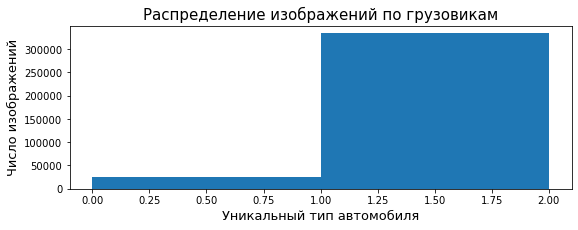

truck: 0 | 25688
no_truck: 1 | 333166


In [8]:
title = 'Распределение изображений по грузовикам'
xlabel = 'Уникальный тип автомобиля'
prepr_hst.plot_hist(truck_hist_data, truck_uniqie, title, xlabel)

for k, v in truck_code_in.items():
    cnt = truck_hist_data.count(v)
    print(f'{k}: {v} | {cnt}')

В данном случае неравномерность классов более ярко выражена, что несколько усложняет процесс обучения, однако абсолютное количество изображений все еще остается достаточно большим с учетом онлайн аугментаций.

## 2. Подготовка обучающей и тестовой выборок

In [9]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
init_dataset_path = os.path.join(datasets_path, '015_model_marka_year_train')

**Обучающая выборка**

In [10]:
output_folder_name = 'sampled_train_truck'
_ = sampling.sample_data(init_dataset_path, datasets_path,
                         truck_indx_f, output_folder_name,
                         min_th=0, max_th=25688, random_state=0)

  0%|          | 0/6151 [00:00<?, ?it/s]

3 GB of free space are needed to complete sampling. Sample? [y/n]: y


  0%|          | 0/2 [00:00<?, ?it/s]

**Тестовая выборка**

Для тестов отберем $15\%$ изображений.

In [11]:
train_dataset_path = os.path.join(datasets_path, 'sampled_train_truck')
_ = sampling.get_test_ds_from_train(train_dataset_path, 0.15,
                                    datasets_path, 'sampled_test_truck',
                                    random_state=0)

  0%|          | 0/5091 [00:00<?, ?it/s]

  0%|          | 0/996 [00:00<?, ?it/s]

**Перепроверка выборок**

In [12]:
train_dataset_path = os.path.join(datasets_path, 'sampled_train_truck')
test_dataset_path = os.path.join(datasets_path, 'sampled_test_truck')

  0%|          | 0/5091 [00:00<?, ?it/s]

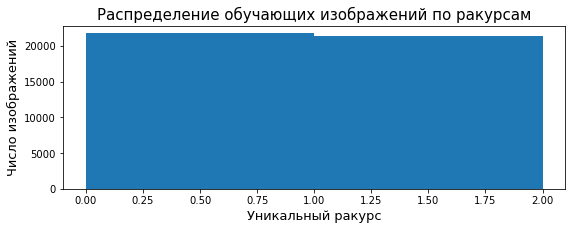

truck: 0 | 21724
no_truck: 1 | 21410


In [15]:
folders_train = os.listdir(train_dataset_path)
indexes_train = indexing.get_indexes(folders_train)

unique_data_tr = prepr_hst.get_unique(indexes_train, truck_indx_f)
truck_t_indxs_tr, truck_uniqie_tr, truck_code_in_tr = unique_data_tr

truck_hist_data_train = prepr_hst.get_hist_data(train_dataset_path,
                                                folders_train,
                                                truck_t_indxs_tr,
                                                truck_code_in_tr)

title_tr = 'Распределение обучающих изображений по ракурсам'
xlabel = 'Уникальный ракурс'
prepr_hst.plot_hist(truck_hist_data_train, truck_uniqie_tr, title_tr, xlabel)

for k, v in truck_code_in_tr.items():
    cnt = truck_hist_data_train.count(v)
    print(f'{k}: {v} | {cnt}')

  0%|          | 0/2902 [00:00<?, ?it/s]

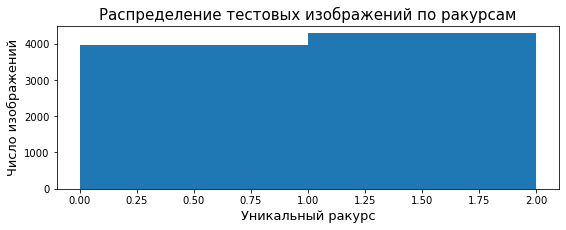

truck: 0 | 3964
no_truck: 1 | 4278


In [17]:
folders_test = os.listdir(test_dataset_path)
indexes_test = indexing.get_indexes(folders_test)

unique_data_ts = prepr_hst.get_unique(indexes_test, truck_indx_f)
truck_t_indxs_ts, truck_uniqie_ts, truck_code_in_ts = unique_data_ts

truck_hist_data_test = prepr_hst.get_hist_data(test_dataset_path,
                                               folders_test,
                                               truck_t_indxs_ts,
                                               truck_code_in_ts)

title_ts = 'Распределение тестовых изображений по ракурсам'
xlabel = 'Уникальный ракурс'
prepr_hst.plot_hist(truck_hist_data_test, truck_uniqie_ts, title_ts, xlabel)

for k, v in truck_code_in_ts.items():
    cnt = truck_hist_data_test.count(v)
    print(f'{k}: {v} | {cnt}')

## 3. Классификатор грузовиков

**Подготовка данных**

In [18]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
train_ds_path = os.path.join(datasets_path, 'sampled_train_truck')
test_ds_path = os.path.join(datasets_path, 'sampled_test_truck')

In [40]:
def transform_labels(lbl):
    return 1 if lbl==0 else 0

In [42]:
classif_ds_train = cust_ds.TLClassifyDataset(
    train_ds_path, truck_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)
classif_ds_train.labels_code = {'truck': 1, 'no_truck': 0}
classif_ds_train.labels = list(map(transform_labels, classif_ds_train.labels))

classif_ds_test = cust_ds.TLClassifyDataset(
    test_ds_path, truck_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)
classif_ds_test.labels_code = {'truck': 1, 'no_truck': 0}
classif_ds_test.labels = list(map(transform_labels, classif_ds_test.labels))

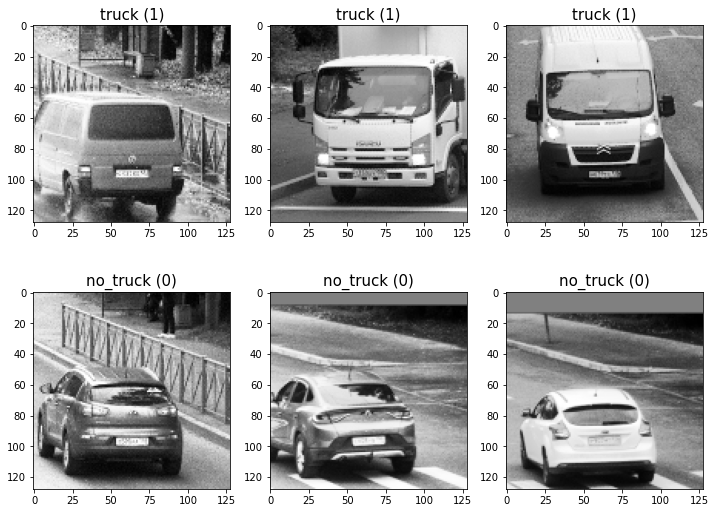

In [43]:
cl_ds_test.classify_ds_test(classif_ds_test, n_rows=2,
                            lines_span=1.5, figsize_sq=3)

**Тест модели**

In [44]:
view_classes_n = len(classif_ds_train.labels_code)
class_truck_model = ClassificationForTLModel(view_classes_n)

Визуальный:

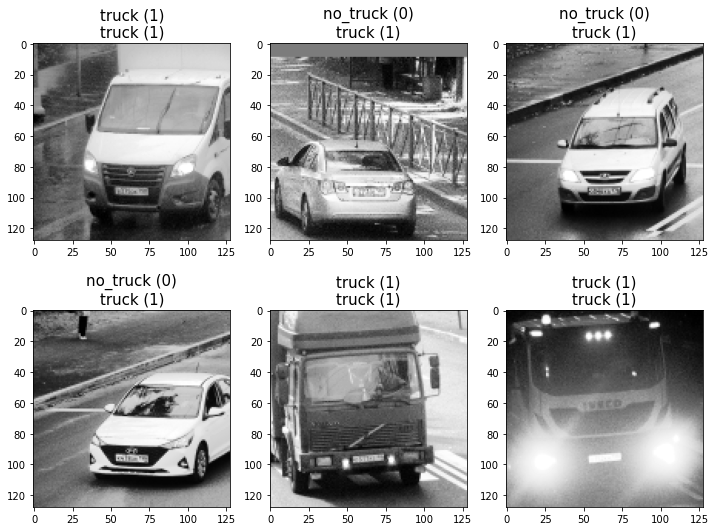

In [45]:
n_rows = 2

t = class_m_test.test_classif_model(class_truck_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy:

In [46]:
acc = CustomAccuracy()

In [47]:
acc_bef_learn = acc.ds_scope(classif_ds_test, class_truck_model)

  0%|          | 0/258 [00:00<?, ?it/s]

In [48]:
print(f'Accuracy модели до обучения: {round(acc_bef_learn, 3)}')

Accuracy модели до обучения: 0.481


f1 score:

In [49]:
f1_score = F1Score()

In [50]:
f1_score_bef_learn = f1_score.ds_scope(classif_ds_test, class_truck_model)

  0%|          | 0/258 [00:00<?, ?it/s]

In [51]:
print(f'f1 score модели до обучения: {round(f1_score_bef_learn, 3)}')

f1 score модели до обучения: 0.312


**Обучение модели**

In [52]:
weights_p = 'weights/6. truck classifier/classif_model_weights_maxAccuracy.pt'
class_truck_model.load_state(weights_p)

Визуальный тест обученной модели:

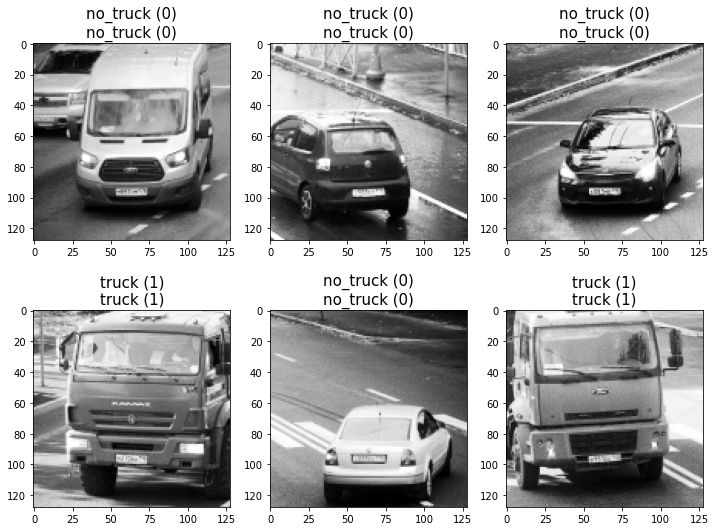

In [53]:
n_rows = 2

t = class_m_test.test_classif_model(class_truck_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy:

In [54]:
acc = CustomAccuracy()

In [56]:
acc_aft_learn = acc.ds_scope(classif_ds_test, class_truck_model)

  0%|          | 0/258 [00:00<?, ?it/s]

In [57]:
print(f'Accuracy модели после обучения: {round(acc_aft_learn, 3)}')

Accuracy модели после обучения: 0.981


f1 score:

In [58]:
f1_score = F1Score()

In [59]:
f1_score_aft_learn = f1_score.ds_scope(classif_ds_test, class_truck_model)

  0%|          | 0/258 [00:00<?, ?it/s]

In [60]:
print(f'f1 score модели после обучения: {round(f1_score_aft_learn, 3)}')

f1 score модели после обучения: 0.981
